In [1]:
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from tqdm import tqdm

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [2]:
ACTIVITY_COLS = [
    'nonproduction',
    'input',
    'remove/cut',
    'paste',
    'replace',
    'move'
]
ACTIVITY2IDX = dict(zip(ACTIVITY_COLS, range(len(ACTIVITY_COLS))))
TEXT_CHANGE_COLS = ['alphanum', 'other']
TEXT_CHANGE2IDX = dict(zip(TEXT_CHANGE_COLS, range(len(TEXT_CHANGE_COLS))))
ACTION_TIME_COLS = [
    'action_time_max',
    'action_time_mean',
    'action_time_std'
]
WORD_COUNT_COLS = ['word_count_max', 'word_count_last']
WAIT_TIME_COLS = ['wait_time_min', 'wait_time_max', 'wait_time_avg', 'wait_time_std']
NUMBER_OF_CHARS_PER_MIN_COLS = [
    'ch_min',
    'ch_max',
    'ch_mean',
    'ch_std'
]
NUMBER_OF_NONCHARS_PER_MIN_COLS = [
    'non_ch_min',
    'non_ch_max',
    'non_ch_mean',
    'non_ch_std'
]


def process_activity(data: pd.Series) -> List[float]:
    """Count activity frequencies

    Parameters
    ----------
    data : pd.Series
        activity data

    Returns
    -------
    List[float]
        activity frequencies
    """

    activity = data.apply(lambda x: 'move' if 'Move' in x else x.lower())
    activity2freq = activity.value_counts(normalize=True)
    res = [0] * len(ACTIVITY_COLS)
    for name, freq in activity2freq.items():
        res[ACTIVITY2IDX[name]] = freq

    return res


def process_text_change(data: pd.Series) -> List[float]:
    text_change = data.apply(lambda x: 'alphanum' if x == 'q' else 'other')
    text_change2freq = text_change.value_counts(normalize=True)
    res = [0] * len(TEXT_CHANGE_COLS)
    for name, freq in text_change2freq.items():
        res[TEXT_CHANGE2IDX[name]] = freq

    return res


def process_wait_time(data: pd.DataFrame) -> List[float]:
    wait_times = data['down_time'][1:].values - data['up_time'][:-1].values
    
    return wait_times.min(), wait_times.max(), wait_times.mean(), wait_times.std()


def process_number_of_chars_per_min(data: pd.DataFrame) -> float:
    last = -1
    res = []
    for t, group in data.groupby('time_ms_int'):
        delta = t - max(0, last)
        last = t
        res.append(group[group['text_change'] == 'q'].shape[0] / delta)
    res = np.array(res)

    return res.min(), res.max(), res.mean(), res.std()


def process_number_of_nonchars_per_min(data: pd.DataFrame) -> float:
    last = -1
    res = []
    for t, group in data.groupby('time_ms_int'):
        delta = t - max(0, last)
        last = t
        res.append(group[group['text_change'] != 'q'].shape[0] / delta)
    res = np.array(res)

    return res.min(), res.max(), res.mean(), res.std()


def prepare_data(
    df: pd.DataFrame,
    labels: Optional[pd.DataFrame] = None
) -> pd.DataFrame:
    """Prepare feature matrix and (optional) labels for a given portion of data

    Parameters
    ----------
    df : pd.DataFrame
        Events DataFrame
    labels : Optional[pd.DataFrame], optional
        Labels DataFrame, by default None

    Returns
    -------
    Tuple[np.ndarray, Optional[np.ndarray]]
        X, y
    """

    data = []
    n_groups = df['id'].nunique()
    for log_id, group in tqdm(df.groupby('id'), total=n_groups):
        tmp = []
        group = group.sort_values(by='down_time')

        # id
        tmp.append(log_id)

        # action_time
        tmp.extend([
            group['action_time'].max(),
            group['action_time'].mean(),
            group['action_time'].std()
        ])

        # wait_time
        tmp.extend(process_wait_time(data=group))

        # activity
        tmp.extend(process_activity(data=group['activity']))

        # text_change
        tmp.extend(process_text_change(data=group['text_change']))

        # word_count
        tmp.append(group['word_count'].max())
        tmp.append(group.tail(1)['word_count'].values[0])

        # log_size
        tmp.append(len(group))

        # Add seconds (as ceil)
        group['time_ms_int'] = np.ceil(group['up_time'] / 1000 / 60).astype(int)

        # Number of chars per minute
        tmp.extend(process_number_of_chars_per_min(data=group))

        # Number of non-chars per minute
        tmp.extend(process_number_of_nonchars_per_min(data=group))

        data.append(tmp)
    res = pd.DataFrame(
        data=data,
        columns=[
            'id', 
            *ACTION_TIME_COLS,
            *WAIT_TIME_COLS,
            *ACTIVITY_COLS, 
            *TEXT_CHANGE_COLS,
            *WORD_COUNT_COLS, 
            'log_size',
            *NUMBER_OF_CHARS_PER_MIN_COLS,
            *NUMBER_OF_NONCHARS_PER_MIN_COLS
        ]
    )
    if labels is not None:
        res = res.merge(labels, on='id', how='left')

    return res

# Load training/test data

In [3]:
df_logs = pd.read_csv('../input/linking-writing-processes-to-writing-quality/train_logs.csv')
df_logs_test = pd.read_csv('../input/linking-writing-processes-to-writing-quality/test_logs.csv')
df_labels = pd.read_csv('../input/linking-writing-processes-to-writing-quality/train_scores.csv')
df_logs.shape, df_labels.shape, df_logs_test.shape

((8405898, 11), (2471, 2), (6, 11))

In [4]:
df_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


# Train data

In [5]:
df_agg = prepare_data(df=df_logs, labels=df_labels)
print(df_agg.shape)
df_agg.head(n=10)

100%|██████████| 2471/2471 [00:20<00:00, 122.89it/s]


(2471, 28)


,id,action_time_max,action_time_mean,action_time_std,wait_time_min,wait_time_max,wait_time_avg,wait_time_std,nonproduction,input,...,log_size,ch_min,ch_max,ch_mean,ch_std,non_ch_min,non_ch_max,non_ch_mean,non_ch_std,score
0,001519c8,2259,116.246774,91.797374,-142,154136,586.932707,4293.182203,0.046930,0.786077,...,2557,0.0,170.0,64.550000,44.886589,1.0,47.0,20.300000,10.010494,3.5
1,0022f953,1758,112.221271,55.431189,-166,145899,604.547493,4896.305312,0.103504,0.789731,...,2454,0.0,181.0,60.464286,57.511789,1.0,114.0,26.875000,26.374238,3.5
2,0042269b,3005,101.837766,82.383766,-250,153886,325.520435,3936.882894,0.042311,0.849855,...,4136,0.0,348.0,119.314815,88.293193,0.5,76.0,32.222222,19.885940,6.0
3,0059420b,806,121.848329,113.768226,-516,101690,754.648232,4240.788383,0.063625,0.838046,...,1556,0.0,97.0,51.659091,28.972317,0.5,38.0,17.522727,8.929620,2.0
4,0075873a,701,123.943896,62.082013,-158,110688,502.094862,3895.439159,0.028447,0.767286,...,2531,0.0,191.0,73.326923,51.041262,1.0,56.0,21.288462,13.038532,4.0
5,0081af50,1102,81.404342,40.653054,-1026,160742,704.205882,6496.582195,0.034374,0.811398,...,2211,0.0,196.0,65.853333,69.380566,0.0,44.0,18.280000,16.503987,2.0
6,0093f095,501,109.717847,37.018331,-135,122688,888.873583,7845.723585,0.019263,0.896884,...,1765,1.0,212.0,56.560000,69.728663,0.0,47.0,13.620000,16.611610,4.5
7,009e23ab,803,90.755631,41.934952,-120,305373,628.914116,7724.389606,0.065873,0.839354,...,2353,0.0,229.0,70.187500,79.957126,1.0,81.0,26.125000,24.703766,4.0
8,00e048f1,613,75.011356,33.244615,-25,214541,1056.396465,8221.619576,0.025868,0.899685,...,1585,0.0,111.0,46.891026,32.507821,1.0,28.0,12.820513,7.809692,3.5
9,00e1f05a,11017,93.343215,198.896690,-226,20817,142.167668,750.461828,0.029134,0.785203,...,7826,9.0,300.0,196.548387,74.219743,17.0,86.0,55.903226,16.731957,4.5


# Test data

In [6]:
df_agg_test = prepare_data(df=df_logs_test)
print(df_agg_test.shape)
df_agg_test.head(n=10)

100%|██████████| 3/3 [00:00<00:00, 497.01it/s]

(3, 27)


,id,action_time_max,action_time_mean,action_time_std,wait_time_min,wait_time_max,wait_time_avg,wait_time_std,nonproduction,input,...,word_count_last,log_size,ch_min,ch_max,ch_mean,ch_std,non_ch_min,non_ch_max,non_ch_mean,non_ch_std
0,0000aaaa,87,86.0,1.414214,421555,421555,421555.0,0.0,0,1.0,...,0,2,0.000000,0.00,0.000000,0.000000,0.142857,0.166667,0.154762,0.011905
1,2222bbbb,67,56.5,14.849242,421408,421408,421408.0,0.0,0,1.0,...,1,2,0.142857,0.20,0.171429,0.028571,0.000000,0.000000,0.000000,0.000000
2,4444cccc,94,75.0,26.870058,450495,450495,450495.0,0.0,0,1.0,...,0,2,0.000000,0.25,0.125000,0.125000,0.000000,0.142857,0.071429,0.071429


In [7]:
columns = df_agg.columns
features_names = columns[1:-1]
features_names

Index(['action_time_max', 'action_time_mean', 'action_time_std',
       'wait_time_min', 'wait_time_max', 'wait_time_avg', 'wait_time_std',
       'nonproduction', 'input', 'remove/cut', 'paste', 'replace', 'move',
       'alphanum', 'other', 'word_count_max', 'word_count_last', 'log_size',
       'ch_min', 'ch_max', 'ch_mean', 'ch_std', 'non_ch_min', 'non_ch_max',
       'non_ch_mean', 'non_ch_std'],
      dtype='object')

In [8]:
X_train = df_agg[features_names].values
y_train = df_agg['score'].values
X_train.shape, y_train.shape

((2471, 26), (2471,))

In [9]:
X_test = df_agg_test[features_names].values
X_test.shape

(3, 26)

# Train model

In [10]:
seeds = [0, 42, 666]
n_trials = 100
clf = xgb.XGBRegressor(eval_metric='rmse')
param_distributions = {
    'n_estimators': optuna.distributions.IntDistribution(2, 50),
    'max_depth': optuna.distributions.IntDistribution(2, 10),
    'learning_rate': optuna.distributions.FloatDistribution(0, 0.5),
    'subsample': optuna.distributions.FloatDistribution(0.75, 1)
}
preds = []
estimators = []
for seed in seeds:
    print(f'Training model for seed {seed}')
    optuna_search = optuna.integration.OptunaSearchCV(
        estimator=clf, 
        param_distributions=param_distributions,
        n_trials=n_trials,
        scoring='neg_mean_squared_error',
        random_state=seed
    )
    optuna_search.fit(X_train, y_train)
    print(f'Best score: {optuna_search.best_score_}')
    print(f'Best params: {optuna_search.best_params_}')
    print()
    y_test = optuna_search.predict(X_test)
    preds.append(y_test)
    estimators.append(optuna_search.best_estimator_)
y_test = sum(preds) / len(preds)

/var/folders/k7/932b6zfd3fz6b1wx81v3k5jw0000gn/T/ipykernel_4295/2575617074.py:14: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(


Training model for seed 0
Best score: -0.47589632756962175
Best params: {'n_estimators': 35, 'max_depth': 3, 'learning_rate': 0.16796153385633106, 'subsample': 0.9554985807063411}

Training model for seed 42


/var/folders/k7/932b6zfd3fz6b1wx81v3k5jw0000gn/T/ipykernel_4295/2575617074.py:14: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(


Best score: -0.4758780147468906
Best params: {'n_estimators': 35, 'max_depth': 2, 'learning_rate': 0.19330780633169659, 'subsample': 0.9280791192461587}

Training model for seed 666


/var/folders/k7/932b6zfd3fz6b1wx81v3k5jw0000gn/T/ipykernel_4295/2575617074.py:14: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(


Best score: -0.47723960937989107
Best params: {'n_estimators': 29, 'max_depth': 2, 'learning_rate': 0.22518109494402527, 'subsample': 0.9081881634843223}



# Feature importance

Estimator #0


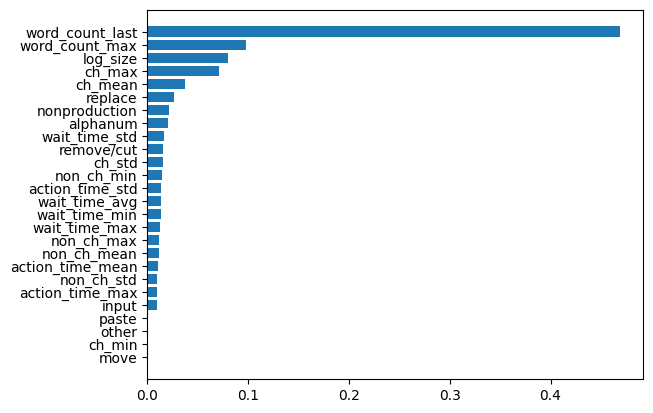

Estimator #1


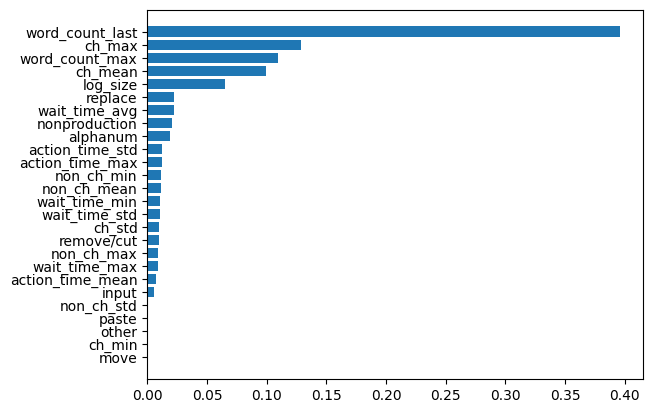

Estimator #2


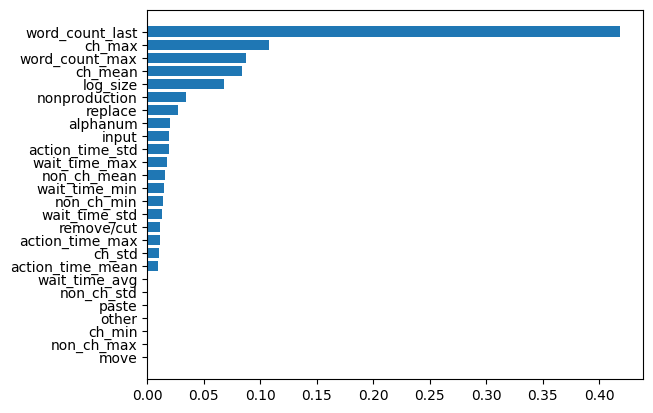

In [11]:
for i, estimator in enumerate(estimators):
    print(f'Estimator #{i}')
    importances = estimator.feature_importances_
    sort_idx = np.argsort(importances)
    plt.barh(features_names[sort_idx], importances[sort_idx])
    plt.show()

# Add test scores

In [12]:
df_agg_test['score'] = y_test
df_agg_test.head()

,id,action_time_max,action_time_mean,action_time_std,wait_time_min,wait_time_max,wait_time_avg,wait_time_std,nonproduction,input,...,log_size,ch_min,ch_max,ch_mean,ch_std,non_ch_min,non_ch_max,non_ch_mean,non_ch_std,score
0,0000aaaa,87,86.0,1.414214,421555,421555,421555.0,0.0,0,1.0,...,2,0.000000,0.00,0.000000,0.000000,0.142857,0.166667,0.154762,0.011905,1.777694
1,2222bbbb,67,56.5,14.849242,421408,421408,421408.0,0.0,0,1.0,...,2,0.142857,0.20,0.171429,0.028571,0.000000,0.000000,0.000000,0.000000,1.555012
2,4444cccc,94,75.0,26.870058,450495,450495,450495.0,0.0,0,1.0,...,2,0.000000,0.25,0.125000,0.125000,0.000000,0.142857,0.071429,0.071429,1.785352


# Save test scores

In [13]:
df_agg_test[['id', 'score']].to_csv('submission.csv', index=False)